# Explainable AI
## Why need Explainable AI?
This notebook will discuss the idea of explainable AI (XAI) in the context of applying machine learning to signals or acoustics. How does XAI work and why need it? Suppose two cases, 1) you have created a model that requires a lot of inputs with near perfect accuracy and/or 2) you have made a new model with poor accuracy but uses similar inputs to the last model. What's the difference between the two models? Why does one model perform better than another and how can we explain this? This has been an interesting question in machine learning because many consider machine learning as a black box diagram where the model handles the intricacies of data processing to come up with a solution. Although the methods provide adequate and robust results, how are the models learning and how do we gain an understanding from the trained models? This is where XAI comes into discussion. The idea behind XAI is to open up the black box and begin investigating why particular features provide adequate information to predict an output or to begin understanding the role that inputs have with each other. By investigating these roles, we can learn from the data and create new insights into our research. From traditional statistical metrics to more complex analytical evaluations of a trained model, we can start to comprehend how models come to solutions and trust the output of these models. While there are a number of popular approaches to XAI, we will focus only a few examples for brevity. In particular, we will go through approaches for interpreting model prediction for both unsupervised supervised models. This will be demonstrated through.

<u>Unsupervised</u>:
1) Feature Visualization
2) Elbow Curve
3) Silhouette Score
4) Davies-Bouldin Index

<u>Supervised</u>:

1) SHapley Additive exPlanations (SHAP)
2) Local Interpretable Model-Agnostic Explanations (LIME)
3) Permutation Importance
4) Saliency Maps

While we have split the topics into unsupervised and supervised techniques, the approaches discussed below are not particular to any one scenario and can be used vice versa. It should be noted that while the techniques discussed above are particular for features and their impact on an output, further investigation into how a machine learning model utilizes the features (i.e. using Bayes theorem, identifying boundaries, etc.) to make decisions should be considered when investigating machine learning models. For example, a support vector machine model may work well when the data is highly seperable in feature space but may fall short in it's predictions when the data needs something more cpmplex.

By: Ryan McCarthy

### Load Packages

In [1]:
# Load Packages
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import librosa 
import librosa.display
import IPython.display as ipd

from glob import glob
import opendatasets as od 

# Unsupervised Investigation
Unsupervised learning is a great tool to group data into particular classes or investigate large data faster without any known apriori information. There are a number of unsupervised techniques that can be used such as k-means clustering, fuzzy clustering, gaussian mixture models, hierarchial clutering, and Density-Based Spatial Clustering (DBSCAN) to name a few. These models provide relatively quick clustering of the data based on the features of the samples and their proximity with each other. When defining these features, the dimensionality can make interpretation of the results, the number of clusters, why clusters are created, or how to evaluate the clusters difficult to understand. Below we demonstrate a few approachs to better interpreting the models prediction and ways to evaluate the cluster's prediction.

We will start by loading in a ~60-second recording of a humpback whale song near Glacier bay, details [here](https://librosa.org/doc/main/recordings.html). This recording will give us a chance to apply and evaluate unsupervised learning techniques.

In [2]:
y,sr = librosa.load(librosa.ex('humpback'))

# Play audio file
ipd.Audio(data=y,rate = sr)

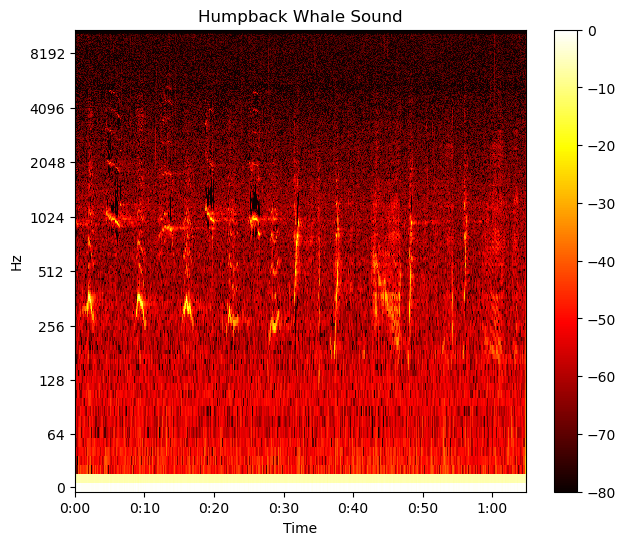

In [3]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(y, n_fft = n_fft, hop_length = hop_length))

# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB = librosa.amplitude_to_db(D, ref = np.max)

# Creating the Spectogram
plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
librosa.display.specshow(DB, sr = sr, hop_length = hop_length, x_axis = 'time', y_axis = 'log',
                        cmap = 'hot')
plt.colorbar();
plt.title('Humpback Whale Sound')
plt.show()

Above we see the spectrogram of the Fast Fourier Transform (FFT) of the recording. We can see that the song is primarly contained within 128-4096 Hz. Although we could manually identify the sounds and similarities in the spectra, we will turn to unsupervised learning to identify clusters. To do this, we will first split the data into segments using the code below before using feature extraction and applying unspervised clustering.

In [4]:
# Function to split the data
def split(a, n):
    data = []
    for m in range(n,len(a),n):
        data.append(a[m-n:m])
    return data

In [5]:
# Pull out samples
data = split(y,sr//2)
data = np.vstack(data)

### Feature Extraction
To cluster similar segments, we will use the feature extraction approach RandOm Convolutional KErnel Transform (ROCKET). ROCKET creates random convolutional kernels of random length and dilation to transform the time series (segments). Two features are then extracted from the convolved segments, namely the proportion of positive values and the global max. Through this unique random convolution approach, we are able to identify key features that may be useful for clustering without prior knowledge. 

In [6]:
from pyts.transformation import ROCKET

In [7]:
# ROCKET transformation (feature extraction)
rocket = ROCKET(n_kernels=500, random_state=42)
X_rocket = rocket.fit_transform(data)
print(f"Samples: {X_rocket.shape[0]}")
print(f"Features: {X_rocket.shape[1]}")

Samples: 129
Features: 1000


## Feature Visualization Embeddings
Once we have selected a feature extraction method, it will be useful to visualize the seperation of the data in the higher dimensions. One way of doing this is through embeddings to reduce the dimensions to something that can be visualized while preserving the spatial distribution of the data and understand how a model may be clustering the data. In the example above, after applying ROCKET to the individual segments, we notice that the data now has 1000 features. Applying clutering to this new feature space requires the model to consider all of these features simultaneously, this is difficult to visulize and interpret how a model is clustering. There are several popular transformations that can help visualize the feature space such as principal component analysis (PCA), Isomapping, or t-distributed stochastic neighbor embedding (t-SNE). We will demonstrate a few of these technqiues to understand how unsupervised models are clustering below. 

### Principal Component Analysis (PCA)
Principal component analysis (PCA) is a great tool to decompose and visualize data. Details of PCA can be found [here](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf) or [here](https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html). The PCA takes a data matrix $X$ of dimensions $m$ x $n$ where $m$ is the number of smaples and $n$ is the number of features and standaridizes the data. After standardization, the covariance matrix is computed for the features. An example of this is seen as:
$$
    \Sigma = \begin{bmatrix}
       \sigma(i,i) & \sigma(j,i) \\\
       \sigma(i,j) & \sigma(j,j)
    \end{bmatrix}
$$
where $\sigma_{i,k} = \frac{1}{n-1}\sum_{i=1}^n(x_{i,j}-\bar{x}_{j})(x_{i,k}-\bar{x}_{k})$ and $\bar{x}$ is the mean vector. The data  decomposes into:
$$
    X = U\Sigma V^T
$$
where $U$ is the left singular vectors and $V$ is the right singular vectors. The new feature space is created using:
$$
    A = \Sigma V^T
$$
where the number of columns of A are the number of components that we can use to reconstruct the original matrix $X$. The resulting PCA of the feature space of the segments is shown below.

In [8]:
from sklearn.decomposition import PCA

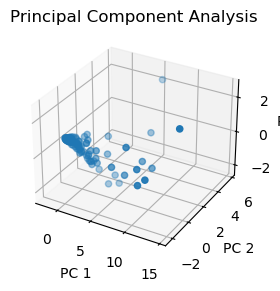

In [9]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
pcavis = pca.fit_transform(X=X_rocket)
ax.scatter(pcavis[:,0],pcavis[:,1],pcavis[:,2])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Principal Component Analysis')
plt.show()

### Multidimensional Scaling (MDS)
Multidimensional Scaling (MDS) is an algorithm that seeks to find a lower order representation of the data that preserves the distances between points. In this notebook we will look at the classical MDS approach which models the similarity or dissimilarity data as distances in a geometric space. A distance matrix $D$ is constructed by calculating some distance metric for sample points i and j as:
$$
    d_{i,j} = ||x_i-x_j||_2
$$
The above distance metric is for Euclidean distance. The algorithm looks to compute a a centered inner-product matrix B by using:
$$
    B = -\frac{1}{2}H(D\odot D)H
$$
where $\odot$ is the Hadamard product of two matrices, and $H = I - \frac{1}{n}J$ where I is the identity matrix and J is a matrix of all ones. We can then find a find a solution by the eigen-decomposition of B using:
$$
    P = \Lambda^{1/2}V'
$$
where $E$ is the matrix of eignevectors, $\Lambda$ is the diagonal matrix of eigenvalues of B, and $B = V\Lambda V'$. We show this transformation below.

In [10]:
from sklearn.manifold import MDS

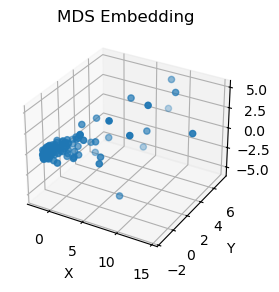

In [11]:
mds = MDS(n_components=3)
X_mds = mds.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_mds[:,0],X_mds[:,1],X_mds[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('MDS Embedding')
plt.show()

### Isomapping
One of the original manifold approaches is the Isometric Mapping algorithm. Details of this approach can be found [here](https://www.science.org/doi/10.1126/science.290.5500.2319). This approach has three main step:
1) Construct a neighborhood graph on a manifold M using a distance matrix between pairs of points. This is done either through a K-nearest neighbors approach or a fixed radius.
2) Estimate the distances between the pairs of points within M by computing the shortest distances.
3) Apply a multidimensional scaling (MDS) embedding of the graph distances that preserves the geometry of the manifold.
In the example below, we use 10 nearest neighbors and extract 3 components. 

In [12]:
from sklearn.manifold import Isomap

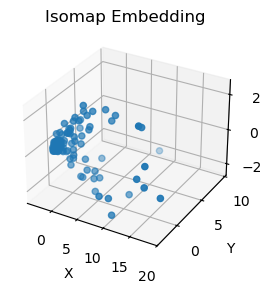

In [13]:
isomap = Isomap(n_neighbors=10, n_components=3)
X_isomap = isomap.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_isomap[:,0],X_isomap[:,1],X_isomap[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Isomap Embedding')
plt.show()

### t-distributed stochastic neighbor embedding (t-SNE) 
t-distributed stochastic neighbor embedding (t-SNE) is a method for visualizing high dimensional data through a nonlinear dimensionality reduction technique. Details of this algorithm can be found [here](https://medium.com/swlh/t-sne-explained-math-and-intuition-94599ab164cf) This is done by first calculating the conditional probability of points next to each other by a Gaussian with mean centered at a point with a standard deviation. This is written as:
$$
    p_{j|i} = \frac{e^{-||x_i-x_j||^2/2\sigma_i^2}}{\sum_{k\neq i}e^{-||x_i-x_k||^2/2\sigma_i^2}}
$$
where $x_i$ and $x_j$ are datapoints in the feature space and $\sigma_i$ is the variance of the Gaussian that is centered at datapoint $x_i$. we can use the conditional probability to calculate the joint probability distribution as:
$$
    p_{i,j} = \frac{p_{j|i}+p_{i|j}}{2n}
$$
where n is the number of points. The algorithm desires to find a mapping that reflects the similarities in $p_{i,j}$ defined as:
$$
    q_{i,j} = \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l}(1+||y_k-y_l||^2)^{-1}}
$$
where $y$ is the d-dimensional map points. Locations of $y$ are determined by minimizing the Kullback-Leibler divergence of $p$ and $q$ as: 
$$
    KL(P||Q) = \sum_i\sum_jp_{j,i}\log(\frac{p_{j,i}}{q_{j,i}})
$$
The resulting mapping of the example is shown below. For further information and an example on using t-SNE, please refer to the website [here](https://distill.pub/2016/misread-tsne/).

In [14]:
from sklearn.manifold import TSNE

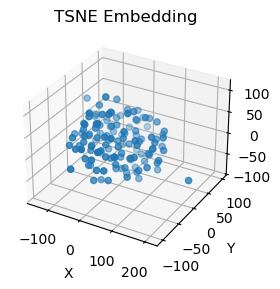

In [15]:
tsne = TSNE(n_components=3,perplexity=20)
X_tsne = tsne.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsne[:,0],X_tsne[:,1],X_tsne[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('TSNE Embedding')
plt.show()

### Spectral Embedding
Spectral embedding calculates a non-linear embedding by implementing Laplacian Eigenmaps to find a low dimensional representation. Details of this method can be found [here](https://ieeexplore.ieee.org/document/6789755). The embedding is done in three steps.
1) The data is transformed into a graph representation using affinity matrix representation.
2) An unnormalized Graph Laplacian is constructed as:

$$
    L = D - W
$$
where $W$ is the weight matrix ($W_{i,j}=e^{-\frac{||X_i-X_j||^2}{t}})$ and $D$ is a diagonal weight matrix consisting of sums of $W$. 

3) Compute eigenvalues and eignevectors to minimiz the objective function using:

$$
    Ly = \lambda Dy
$$
where $\lambda$ are the eigenvalues. The resulting embedding can be seen below.

In [16]:
from sklearn.manifold import SpectralEmbedding

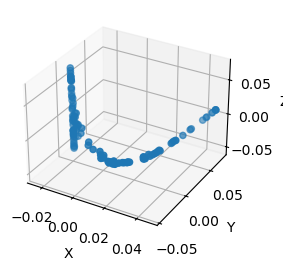

In [17]:
specemb = SpectralEmbedding(n_components=3)
X_specemb = specemb.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_specemb[:,0],X_specemb[:,1],X_specemb[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('')
plt.show()

# Apply Kmeans clustering
K-means clustering is an unsupervised learning algorithm used to cluster data by choosing centroids to minimize the within-cluster sum of squares as:
$$
    \sum_{i=0}^n \min_{\mu_j \in C}(||x_i - \mu_j||^2)
$$
where $C$ is the centroid of a cluster and $\mu$ is the mean. The centroids of the clusters are adjusted and iterated at every step to minimize the within cluster distance. Points are clustered together based on the minimum distance from the given centroids. Further details are provided [here](https://scikit-learn.org/1.5/modules/clustering.html#k-means).

In [18]:
from sklearn.cluster import KMeans

In [19]:
clusters = range(1, 10)
kmodel = [KMeans(n_clusters=i) for i in clusters]
score = [kmodel[i].fit(X_rocket).inertia_ for i in range(len(kmodel))]

C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

## Visual Interpretation
Using the embeddings that we defined earlier, we can evaluate a model's unsupervised clustering by looking at the clustering in the new embedded space. For the example below, we will take the Spectral embedding to visualize the data and see how the kmeans clustering has grouped the data.

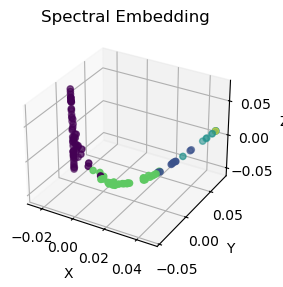

In [20]:
classes = kmodel[4].predict(X_rocket)

specemb = SpectralEmbedding(n_components=3)
X_specemb = specemb.fit_transform(X_rocket)

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_specemb[:,0],X_specemb[:,1],X_specemb[:,2],c=classes)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Spectral Embedding')
plt.show()

Colors represent different groupings found by the K-means algorithm. We can see that there are some groups with individual samples and other samples that could be put into different groups. This approach helps to visualize the grouping based on the features.

## Elbow Curve
The elbow curve method is a good method to pick out the number of clusters to use. For unsupervised learning, there a number of different methods you could use. One method is the inertia method. This method measures the distance between the samples and its centroid in the feature space, squaring this distance, and summing these squares for each cluster. By finding where the curve flattens out, this will tell us how many clusters is optimal to use before it begins to over-cluster.

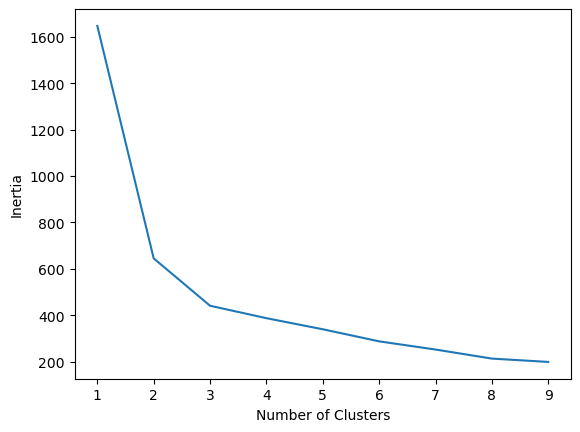

In [21]:
plt.plot(clusters,score)
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.show()

We can see that after 3 clusters, the inertia begins to flatten out potentially meaning that 3 clusters may be optimal for this dataset. 

## Silhouette Score
A silhouette score of 1 indicates that the samples are well seperated and the points within clusters are far away from each other. A silhouette score of 0 indicates taht the distance between the clusters is not significant and samples are bordering cluster groups. Finally, a negative score indicates that the samples could be assigned to the wrong cluster. The score for silhouette is calculated as:

$$
    silhouette = \frac{b-a}{\max(a,b)}
$$
where $a$ is the average distance between a sample and the other samples in it's cluster in feature space and $b$ is the average distance between a sample and the other samples in the neighboring cluster.

In [22]:
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.cm as cm

For n_clusters = 4 The average silhouette_score is : 0.5098651849916169


C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


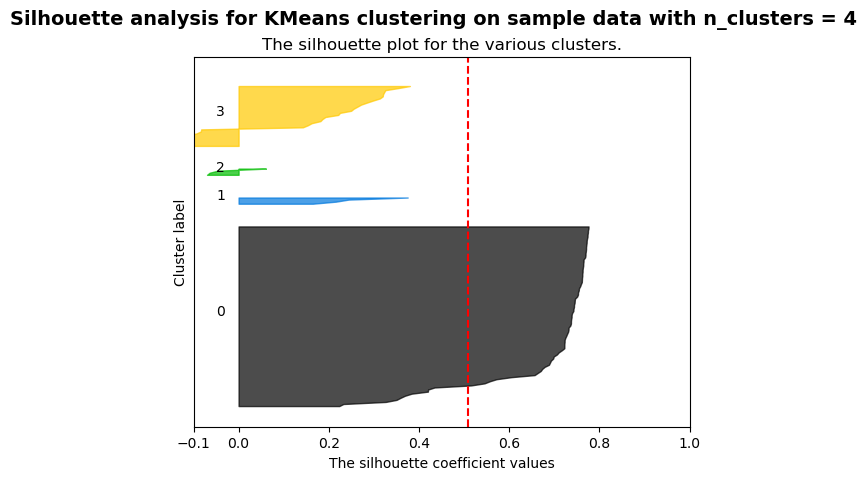

In [23]:
n_clusters = 4

fig= plt.figure()
ax = fig.add_subplot()

# The 1st subplot is the silhouette plot
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X_rocket) + (n_clusters + 1) * 10])

cluster_labels = kmodel[n_clusters].fit_predict(X_rocket)
    
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_rocket, cluster_labels)
print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg,)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_rocket, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7,)

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

ax.set_yticks([])  # Clear the yaxis labels / ticks
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for {kmodel[n_clusters].__class__.__name__} clustering on sample data with n_clusters = {n_clusters}",fontsize=14,fontweight="bold")

plt.show()

The silhouette score above indicates that the data points are bordering clusters and that the distance between the clusters is not as significant. The plot above shows the coefficient values for the samples in each cluster. a majority of the samples in cluster 3 are above 0.5 which means that they are clustered very well. Conversely, in clusters 1 and 0, there are negative points which indicate that the samples may be in the wrong cluster.

## Davies-Bouldin Index
Davies-Boulding Index (DBI) evaluates the performance of a clustering algorithm by measuring the average similarity of each cluster by comparing the distance between clusters to the size of the clusters. A lower DBI indicates that the clustering has better separation between the clusters. A higher values indicates that the groupings are not that well seperated and could potentially lead to overlap in clusters. The average similarity is defined as:

$$
    DB = \frac{1}{N}\sum^N_{i=1}\max_{j\neq i}(\frac{s_i+s_j}{d_{ij}})
$$
where $N$ is the number of clusters, $s$ is the average within cluster distance, and $d$ is the between cluster distance of cluster $i$ and $j$. Further details of the DBI implementation can be found [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4766909). We can calculate the DBI for various number of clusters or clutering algorithms to determine the best solution. To do this we can plot the DBI for various clusters and identify the elbow point.

In [24]:
from sklearn.metrics import davies_bouldin_score

In [25]:
clusters = range(2, 10)
kmodel = [KMeans(n_clusters=i) for i in clusters]
score_db = [davies_bouldin_score(X_rocket,kmodel[i].fit(X_rocket).predict(X_rocket)) for i in range(len(kmodel))]

C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ryan-\anaconda3\envs\audioenv1\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

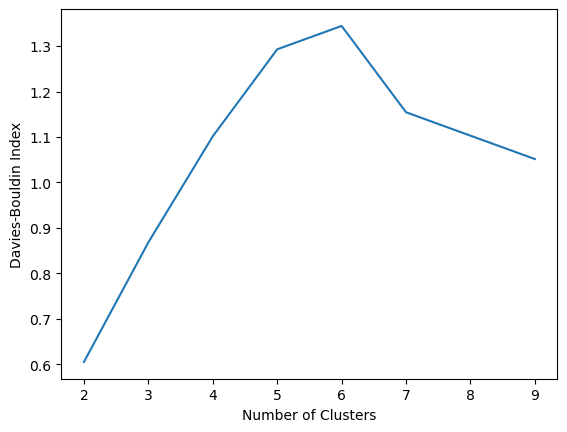

In [26]:
plt.plot(clusters,score_db)
plt.ylabel('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.show()

# Supervised Investigation

Now that we have reviewed some techniques for evaluating unsupervsied clustering, we will now get into some techniques and algorithms for evaluating supervised machine learning techniques. Supervised machine learning algorithms have the benefit of predicting an output with a known output. Models under this category can include deep nueral networks, decision trees, support vector machines, etc. which predict an output based on a given input.

To discuss this topic, we will use the AudioMNIST dataset to discuss various XAI approaches. The Modified National Institute of Standards and Technology (MNIST) dataset is a database that contains digits ranging from 0 to 9. This dataset is used for a number of applications including as a testbed for new machine learning approaches. In recent years, a new audio verison of the dataset has been released called AudioMNIST. The AudioMNIST dataset is an acoustic database consisting of 30,000 recordings of spoken digits in english with 50 repetitions from 60 different speakers of different nationalities. Description of the dataset and details can be found [Becker 2024](https://www.sciencedirect.com/science/article/pii/S0016003223007536#bfn2) and [in Github](https://github.com/soerenab/AudioMNIST). Given this dataset, we will explore a feature extraction and classification approach for classifying spoken digits. 

In [27]:
od.download('https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist/data')

Skipping, found downloaded files in ".\audio-mnist" (use force=True to force download)


Data will be processed using means and standard deviations of Mel-Frequency Cepstral Coefficients (MFCC). To get a step by step description of MFCC, please see [Mel Frequency Cepstral Coefficient and its Applications: A Review](https://ieeexplore.ieee.org/abstract/document/9955539). We have also provided a description of MFCC in the "DT_RF -- Number Identification" notebook. 

In [28]:
def get_audio(sample=1,digit=0,index=0):
    # Modified file location
    file = f"audio-mnist/data/{sample :02d}/{digit}_{sample :02d}_{index}.wav"
    
    # Get Audio from the location
    data,sr = librosa.load(file)

    # return data and sample rate
    return data,sr

def extract_features_mfcc(file):
    # Load audio and sample rate of audio
    audio,sample_rate = librosa.load(file)
    # Extract features using mel-frequency coefficient
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)
    
    # Scale the extracted features
    extracted_features = np.concatenate((np.mean(mfccs.T,axis=0),np.std(mfccs.T,axis=0)))
    # Return the extracted features
    return extracted_features

def preprocess_and_create_dataset_mfcc():
    # Path of folder where the audio files are present
    root_folder_path = "audio-mnist/data/"
    # Empth List to create dataset
    dataset = []
    
    # Iterating through folders where each folder has audio of each digit
    for folder in tqdm(range(1,61)):
        folder = os.path.join(root_folder_path,f'{folder:02d}')
        
        # Iterate through each file of the present folder
        for file in os.listdir(folder):
            # Path of the file
            file_path = os.path.join(folder,file)
            # Pass path of file to extracted_features() function to create features
            extracted_features = extract_features_mfcc(file_path) 
            # Class of the audio,i.e., the digit it represents
            class_label = int(file[0])

            # Append a list where the feature represents a column and class of the digit represents another column
            dataset.append([extracted_features,class_label])
    
    return pd.DataFrame(dataset,columns=['features','class'])

In [29]:
Data_mfcc = preprocess_and_create_dataset_mfcc()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:19<00:00,  2.32s/it]


## Train a model (Classifier)
We will train a model to predict the class number that is being said in the MNIST dataset. The classifier that is being used is a random forest model (please read through the DT_RF -- Number Identification notebook).  

#### Import packages

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
X_mfcc = np.vstack(Data_mfcc['features'].values)
X_mfcc = pd.DataFrame(X_mfcc)
y_mfcc = np.array(Data_mfcc['class'].values)
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(X_mfcc, y_mfcc, test_size=0.20, shuffle=True, random_state=42)
scaler_mfcc = StandardScaler()
X_train_mfcc = scaler_mfcc.fit_transform(X_train_mfcc)
X_test_mfcc = scaler_mfcc.transform(X_test_mfcc)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_mfcc, y_train_mfcc)

RandomForestClassifier(random_state=42)

Now that we have trained our model, let's start looking at how the model learned through a variety of model statistics and explainable AI algorithms. In the model trained above, features 0-59 are averages in time of the MFCC features and features 60-119 are standard deviations of MFCC features.  

## Statistical Scores
An initial way to understand if a model is performing well is through various statistical scores. This provides us an initial view into if we trained our model correctly, the features are useful for the application, or if we need to try different models. There are four classifications a model can have. True Positive (TP), True Negative (TN), False Positive (FP), and False Negative (FN). In the case of  of errors that can be included in the statis Some initial statisics can include:

<u>Accuracy</u>:
$$
    Accuracy = \frac{TP+TN}{TP+TN+FP+FN} 
$$
<u>Precision</u>:
$$
    Precision = \frac{TP}{TP+FP}
$$
<u>Recall</u>:
$$
    Recall = \frac{TP}{TP+FN}
$$
$F_1$:
$$
    F_1 = 2*\frac{Precision*Recall}{Precision + Recall}
$$


In [32]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [33]:
ypred = rf.predict(X_test_mfcc)
print(f"Accuracy: {accuracy_score(y_test_mfcc,ypred)}")
print(f"Precision: {precision_score(y_test_mfcc,ypred,average='macro')}")
print(f"Recall: {recall_score(y_test_mfcc,ypred,average='macro')}")
print(f"F1: {f1_score(y_test_mfcc,ypred,average='macro')}")

Accuracy: 0.9868333333333333
Precision: 0.9867818353542466
Recall: 0.9868215652170145
F1: 0.986783877211937


## Receiver Operator Curve

We can also represent performance through receiver operating curves (ROC) curves which demonstrates how well a model performs with the given output threshold. ROCs typically consist of true positive rate or sensitivity (i.e. $\frac{TP}{TP+FN}$) and false positive rate (i.e. $\frac{FP}{TN+FP}$). A given classifier machine learning model outputs a prediction value that (similar to probability) which can be threshold to make a decision. A higher threshold will yield stricter predictions. 

In [34]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

In [35]:
def plotrocdisplay(y_ohc,y_prob,title):
    display = RocCurveDisplay.from_predictions(
    y_test_ohc[:,class_label],
    y_pred_prob[:,class_label],
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Micro-averaged One-vs-Rest\nROC Class {title}",
    )

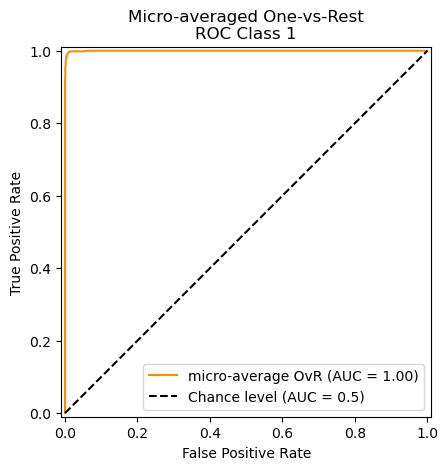

In [36]:
y_test_ohc = LabelBinarizer().fit_transform(y_test_mfcc)
y_pred_prob = rf.predict_proba(X_test_mfcc)
class_label = 1

plotrocdisplay(y_test_ohc[:,class_label],y_pred_prob[:,class_label],class_label)

The above shows the ROC plot for the class that is chosen. ROC curves are created by varying the cut-off probability of the model (ranging from 0 to 1) for a given class. The black dashed line represents the $50\%$ accuracy line (to determine if the model is guessing). A ROC curve that is in the upper left corner indicates a perfect predictor while a curve that is to the bottom right indicates that the model is perfectly predicting the opposite. In many cases, the area under the curve (AUC) indicates the prediction power of the model. The closer the AUC is to 1, the better the prediction capability.

## Precision Recall Curve
Similar to the ROC, we can plot the precision vs recall of the model as we adjust the cutoff threshold. This curve provides details of the tradeoff between precision and recall at different thresholds. Moreover, this curve can provide helpful information when there is a class imbalance in the dataset. Further details of these plots can be found [here](https://scikit-learn.org/1.5/auto_examples/model_selection/plot_precision_recall.html).

In [37]:
from sklearn.metrics import PrecisionRecallDisplay,precision_recall_curve

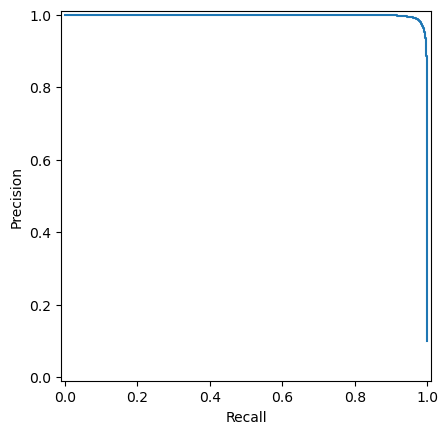

In [38]:
ypred = rf.predict(X_test_mfcc)
prec, recall, _ = precision_recall_curve(y_test_ohc.ravel(), y_pred_prob.ravel() )#pos_label=rf.classes_[5])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

Used to evaluate the performance of a binary classification (in the above case a one vs rest). This provides a representation of a classifiers performance across a number of thresholds. A perfect classifier will have a curve that is toward the top right of the plot. Conversely, if a model is predicting completely incorrectly, the curve will be toward the bottom left. Similar to the AUC in the ROC curves, we can calculate the AUC to performance of the classifier where a higher value indicates a better classifier.

## Confusion Matrix
When there are multiple classes to predict, it can be difficult to visualize where the model may be having difficulties or which classes the model is mislabeling. To visualize this, we can plot the confusion matrix. The confusion matrix is a matrix where the ground truth labels are on the y axis and the predicted labels from the classifier are on the x axis. The numbers inside the matrix indicate the number of predictions that align with those classes. If we look at a row on the confusion matrix, this will tell us what the model classified all the samples with that class. If we take a column on the confusion matrix, the column indicates the predicted class and each row of that column indicates the true label. Let's look at the confusion matrix below to get a better understanding.

In [39]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

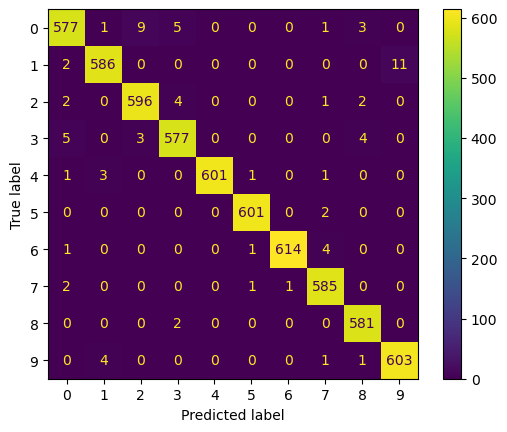

In [40]:
ypred = rf.predict(X_test_mfcc)
ConfusionMatrixDisplay(confusion_matrix(y_test_mfcc,ypred)).plot()

A good confusion matrix will have zeros in the off diagonals and high numbers along the diagonal. In this representation we can see that the model tends to missclassify the number 9 as 1 (seen in the last column). In addition, the number 1 seems to get confused with other numbers (seen in the first column).

# Train a Model (Regression)
Let's now take the AudioMNIST dataset and look at a regression task. Instead of classifying the sounds as numbers, we will try to predict the number from the values (as a way to try to get closer to the correct value). Through this example we will show different ways to analyze model performance for regression models. We will create a Random Forest Regressor and demonstrate this. 

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [42]:
X_mfcc_r = np.vstack(Data_mfcc['features'].values)
X_mfcc_r = pd.DataFrame(X_mfcc_r)
y_mfcc_r = np.array(Data_mfcc['class'].values)
X_train_mfcc_r, X_test_mfcc_r, y_train_mfcc_r, y_test_mfcc_r = train_test_split(X_mfcc_r, y_mfcc_r, test_size=0.20, shuffle=True, random_state=42)
scaler_mfcc = StandardScaler()
X_train_mfcc = scaler_mfcc.fit_transform(X_train_mfcc_r)
X_test_mfcc = scaler_mfcc.transform(X_test_mfcc_r)

rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_mfcc_r, y_train_mfcc_r)

RandomForestRegressor(random_state=42)

### Statistical Metrics (Regression)
There are a few statistical measures we can use to determine the model performance. In particular, we use the root mean squared error and the coefficient of determination ($R^2$) below. The root mean squared error is calculated as:
$$
    RMSE = \sqrt{\frac{\sum_{i=1}^N(x_i-\hat{x_i}^2)}{N}}
$$
A perfect RMSE score would be at 0. A bad score depends on the application that you are doing. In the case where the values are large, a small RMSE is not as alarming. The ($R^2$) is calculated as:
$$
    R^2 = 1-\frac{RSS}{TSS}
$$
where $RSS$ is the sum of squares of residuals and $TSS$ is the total sum of squares. This provides a meausre of how well an observed prediction is replicated by the model given the feature inputs. Similarly, this can indicate the proportion of variance in the dependent variable that is explained by the independent variable. A score can range from 0 to 1 where 1 represents a perfect fit. These two metrics provide an average error and goodness of fit of the model predictions to the ground truth data.

In [43]:
from sklearn.metrics import root_mean_squared_error,r2_score

In [44]:
y_pred_r = rfr.predict(X_test_mfcc_r)
print(f'RMSE: {root_mean_squared_error(y_pred_r,y_test_mfcc_r)}')
print(f'R2: {r2_score(y_pred_r,y_test_mfcc_r)}')

RMSE: 1.032326337291976
R2: 0.8100729810923728


### One to One Plot
A scatter plot can help show how well a model is at predicting values. A perfect regression model would have all predicted values be along the diagonal of the plot. In many cases there is a spread of points around the line demonstrating where potential errors may be.

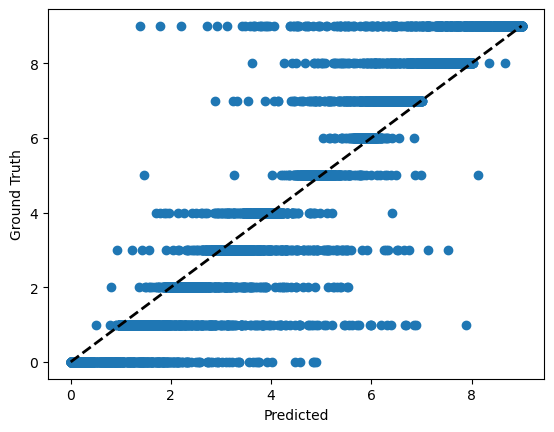

In [45]:
plt.scatter(y_pred_r,y_test_mfcc_r)
x = np.linspace(0,9)
plt.plot(x,x,'k--', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.show()

### Histogram of Residuals
A histogram of residuals provides intuition on the spread of errors for all predictions (note: this can also be used for individual predictions but can also be seen in the previous plot). 

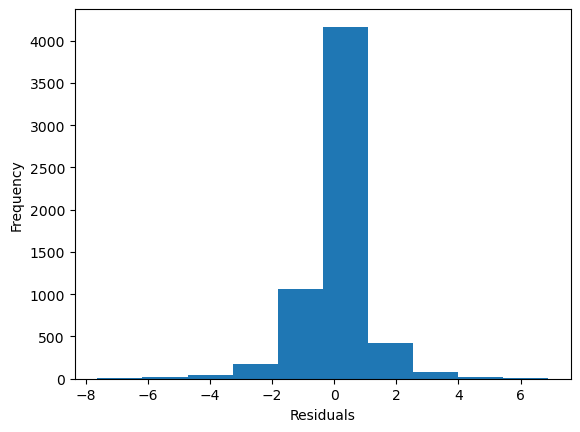

In [46]:
plt.hist(y_pred_r-y_test_mfcc_r)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

On average the model has low residuals and relatively accurate preditions.

### Boxcar Residuals
Boxcar residuals is another way to demonstrate density of errors that a model has. In this example, we have split the boxcars into 10 different classes (the classes of the numbers) and have shown a boxcar error distribution for each.

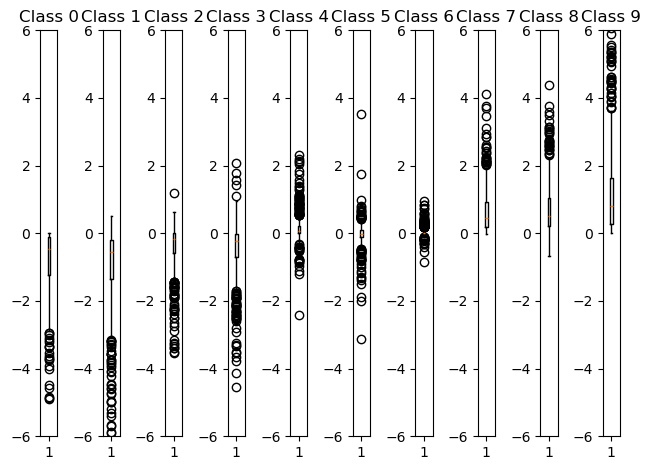

In [47]:
for en,n in enumerate(np.unique(y_test_mfcc_r)):
    plt.subplot(1,10,en+1)
    tr = y_test_mfcc_r==en
    plt.boxplot(y_test_mfcc_r[tr]-y_pred_r[tr])
    plt.title(f'Class {en}')
    plt.ylim(-6,6)
plt.tight_layout()
plt.show()

in the above example we can see that classes 1, 2, 7, 8, and 9 are all skewed either lower or higher.

## SHAP 
SHapley Additive exPlanations is a game theoretic approach to explain the output of any machine learning model. It connects features and their contributions toward the final prediction with local explanations using the classic Shapley values from game theory. Further details can be found [here](https://gtl.csa.iisc.ac.in/gametheory/ln/web-cp5-shapley.pdf). We will define a brief description of the Shapley theorem value below. The equation for Shapley is defined as:
$$
    \psi = \sum_{S \subseteq N/ \{i\}}\frac{|S|!(n-|S|-1)!}{n!} [f_x(S \cup \{i\})-f_x(S)]
$$
where $S$ is all feature subsets of features,$\frac{|S|!(n-|S|-1)!}{n!}$ is the probability that the members of $S$ are ahead of a player $i$ in any permutation, $f_x(S \cup \{i\})-f_x(S)$ is the marginal contribution of plaer $i$ to the worth of $S$, ($N,f_x$) is a given game in coalitional form. Although we give a brief equation and explanation of SHAP, we invite the reader to read through [here](https://gtl.csa.iisc.ac.in/gametheory/ln/web-cp5-shapley.pdf) for more details. Also note that the above equation requires us to compute the model’s prediction for any subset of features.

In [48]:
import shap
import pickle
shap.initjs()

*** Disclamer: the below code takes a while to run. If you want to run, please allow about an hour of runtime. *** 

We have commented out the code to calculate the shap values and have included a pickled version of the data as well.

In [49]:
#%%time
#explainer = shap.TreeExplainer(rf)
#shap_values = explainer.shap_values(X_train_mfcc)

In [50]:
#d = {'explainer':explainer,'shap_values':shap_values}
#with open('shapvalues.pkl', 'wb') as handle:
#    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
# load previously run shap values
with open("shapvalues.pkl", "rb") as f:
    tempshapvalues = pickle.load(f)
explainer = tempshapvalues['explainer']
shap_values = tempshapvalues['shap_values']

In [52]:
X_train_mfcc_df = pd.DataFrame(X_train_mfcc)

### Force Plot
If we want to look at a single sample and understand how the model is using the features to predict the class we can look at the force plot. This plot can help us determine what features are being used and can give us insight to where the model may be predicting incorrectly. If the model is heavily relient on a particular feature, the slightest variation in that feature may cause an incorrect classification. For example, In the case of acoustics, if there is a frequency component that the model relies on to make a prediction and ambient background noise is introduced within that frequency band, it may cause an incorrect classification. 

In [53]:
sample = 0 # sample number
outnum = 5 # class value 
shap.force_plot(explainer.expected_value[outnum],
    shap_values[sample,:,outnum],X_train_mfcc_df.iloc[sample])

Let's walk through the above plot. In this example we are looking at the score that the random forest classifier gives to classify the first sample as class five. The top line represents the base value, or the model's score that the sample was given to be classified as the class. Numbers of the base value can represent probability. The red lines are demonstrating what features are pushing the model to predict the sample as the class. Blue lines identify the features that are providing negative scores (i.e. indicating that the sample is not this class). The number to the left of the '=' are the features being used. In this case, the 1st, 2nd, and 61st feature pulled from the MFCC are providing the most information for the model to predict the sample as class 5. Interpreting these values can be difficult for one sample. For instance, the model using the 2nd feature does not indicate that the 2nd feature is the most important for overall prediction, for this particular sample it happens to be the most important. Let's now look at the same sample but for a different class.

In [54]:
outnum = 0 # class value
shap.force_plot(explainer.expected_value[outnum],
    shap_values[sample,:,outnum],X_train_mfcc_df.iloc[sample])

Above we see that features 63, 2, and 68 had the highest score pushing the predicted value lower. This class value is lower demonstrating that the model is finding the first sample unlikely to be class 0. Through this interpretation, we can investigate particular cases to understand model predictability for a particular sample. 

## SHAP Summary Plot
Summary plots can be great for understanding feature importance for a model. Below we will show off two plots, 1) a bar plot and 2) a density plot. 

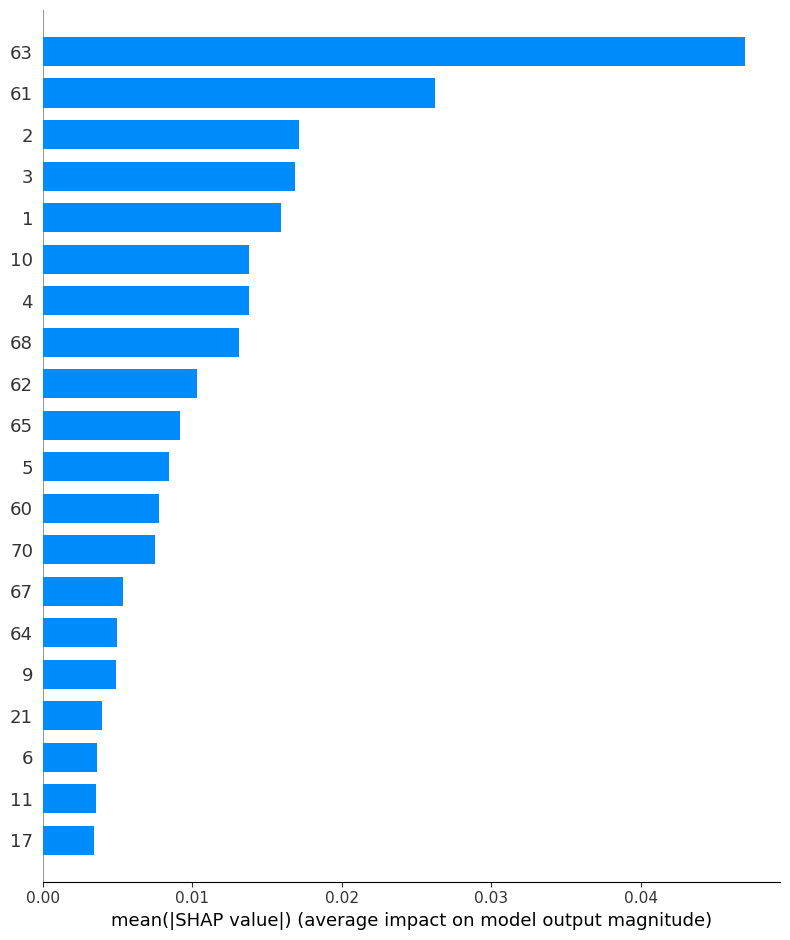

In [55]:
outnum = 0 # class value
shap.summary_plot(shap_values[:,:,outnum], X_train_mfcc_df,plot_type="bar")

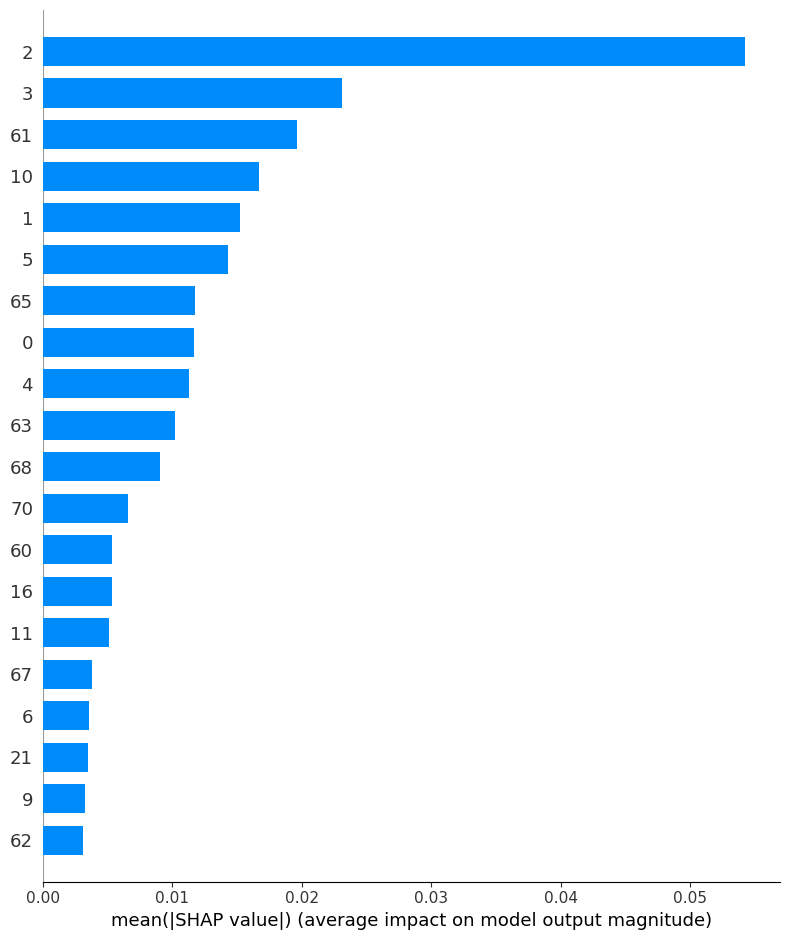

In [56]:
outnum = 5 # class value
shap.summary_plot(shap_values[:,:,outnum], X_train_mfcc_df,plot_type="bar")

The bar plot shows the average impact that a feature has on the classification of a single sample. In the plot above we can see that the first two features have a large impact on the overall result while the following features have an important but not as substantial impact on the classification.

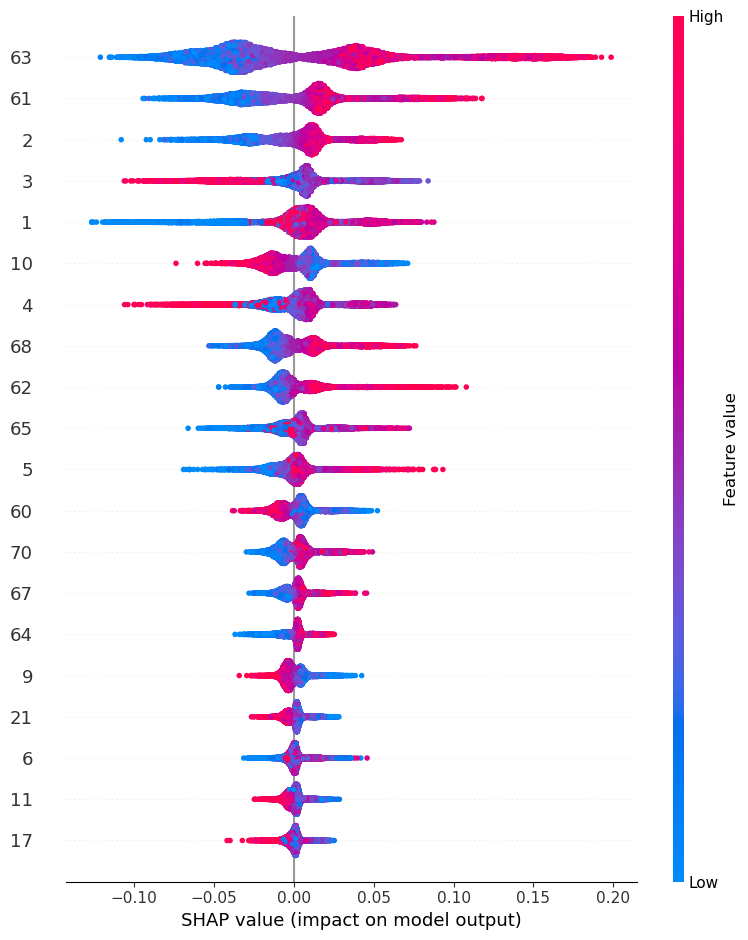

In [57]:
outnum = 0 # class value
shap.summary_plot(shap_values[:,:,outnum], X_train_mfcc_df)

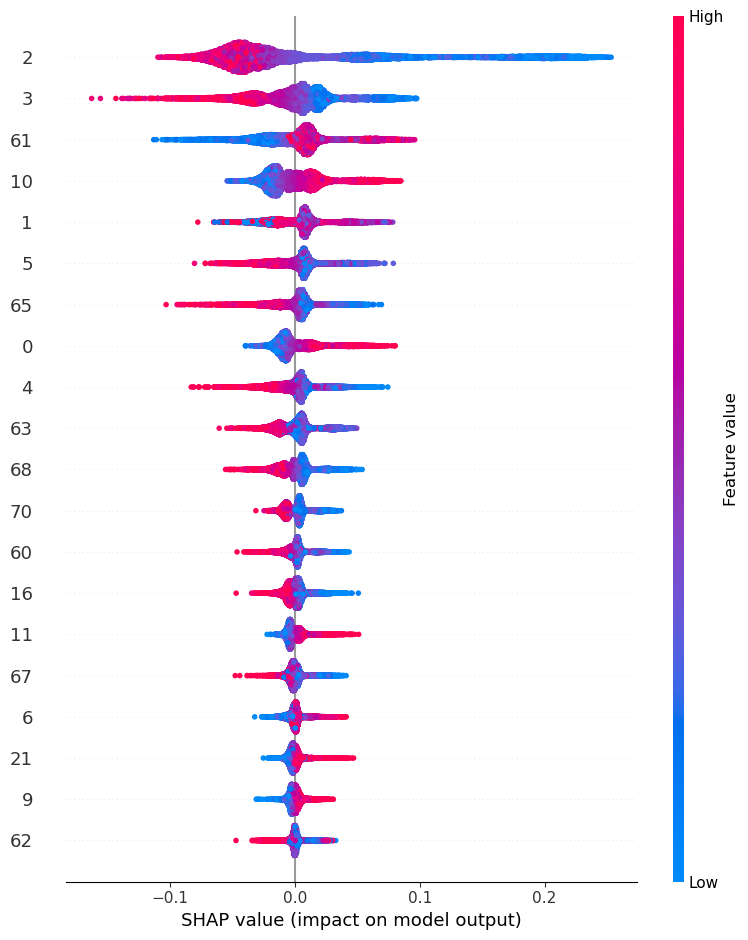

In [58]:
outnum = 5 # class value
shap.summary_plot(shap_values[:,:,outnum], X_train_mfcc_df)

# Lime
Local Interpretable Model-agnostic Explanations (LIME) is used to focus on explaining a model's prediction for individual samples. The LIME algorithm explains the data point $x$ for the machine laerning model $f$ by minimzing the locality-aware loss $L$ while keeping the model complexity $\Omega(g)$ low. This is seen as:
$$
    \arg\min_{g\in G} L(f,g,\pi_x)+ \Omega(g)
$$
where $g$ is the explanation model for $x$ (e.g. linear regression). We can choose the complexity of the model by selecting the max number of features that the model $g$ may use. Further details can be found [here](https://christophm.github.io/interpretable-ml-book/lime.html).

In [59]:
import lime
import lime.lime_tabular

In [60]:
L = lime.lime_tabular.LimeTabularExplainer(X_train_mfcc,class_names=rf.classes_,discretize_continuous=True)

In [61]:
sample = 5
exp = L.explain_instance(X_train_mfcc[sample,:],rf.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

The LIME algorithm produces three different plots. The first plot (i.e. the predicted value for sample 5) outputs that the probability that the sample belongs to a class (in this case, the probability that the sample is class 7 is 0.96). The second plot shows which features have positive and negative influence on the predicted ouptut. In the above, features 2 and 63 have positive influence while 61, 1, and 65 have negative influence. The bottom plot shows the overal value each of the features provides.

## Permutation Importance
Another approach to understand how the features are impacting the models predictions is through permutation importance. This approach randomly permutates a given feature input and evaluates the resulting accuracy to determine the impact of a given feature. Given a feature, $j$, we apply $K$ permutations to the feature and compute the score, $s$, of the model on the dataset. The resulting importance is seen as:
$$
    i_j = s - \frac{1}{K}\sum^K_{k=1} s_{k,j}
$$
Further details can be found [here](https://scikit-learn.org/1.5/modules/permutation_importance.html).

In [62]:
from sklearn.inspection import permutation_importance

In [63]:
r = permutation_importance(rf, X_test_mfcc, y_test_mfcc,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"Feature {i}: "
              f" {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Feature 63:  0.058 +/- 0.002
Feature 61:  0.057 +/- 0.002
Feature 1:  0.053 +/- 0.002
Feature 2:  0.041 +/- 0.002
Feature 3:  0.025 +/- 0.001
Feature 4:  0.021 +/- 0.002
Feature 65:  0.015 +/- 0.001
Feature 5:  0.007 +/- 0.001
Feature 60:  0.006 +/- 0.001
Feature 10:  0.006 +/- 0.001
Feature 62:  0.004 +/- 0.001
Feature 6:  0.004 +/- 0.001
Feature 68:  0.002 +/- 0.001
Feature 70:  0.002 +/- 0.001
Feature 67:  0.002 +/- 0.001
Feature 11:  0.002 +/- 0.001
Feature 0:  0.002 +/- 0.000
Feature 13:  0.002 +/- 0.001
Feature 16:  0.002 +/- 0.001
Feature 17:  0.002 +/- 0.001
Feature 9:  0.001 +/- 0.001
Feature 64:  0.001 +/- 0.000
Feature 12:  0.001 +/- 0.000
Feature 7:  0.001 +/- 0.000
Feature 66:  0.001 +/- 0.000
Feature 15:  0.001 +/- 0.000
Feature 21:  0.001 +/- 0.000
Feature 18:  0.001 +/- 0.000
Feature 119:  0.001 +/- 0.000
Feature 97:  0.001 +/- 0.000
Feature 89:  0.001 +/- 0.000
Feature 40:  0.001 +/- 0.000
Feature 75:  0.001 +/- 0.000


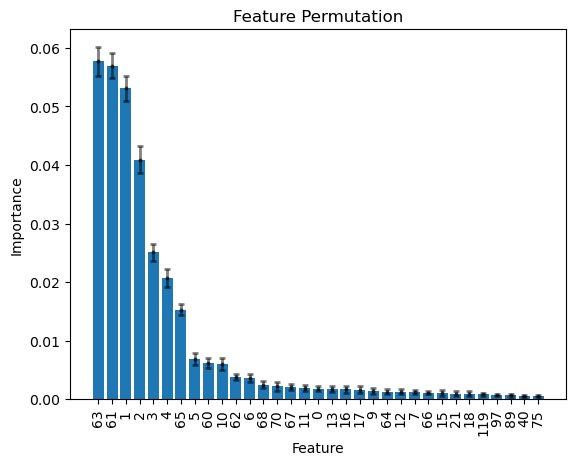

In [64]:
permnames = []
permmeans =  [] 
permstds = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        permnames.append(str(i))
        permmeans.append(r.importances_mean[i])
        permstds.append(r.importances_std[i])

plt.figure()
plt.bar(permnames, permmeans)
plt.title('Feature Permutation')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.errorbar(permnames, permmeans, permstds, fmt='.', color='Black', elinewidth=2,capthick=2,errorevery=1, alpha=0.5, ms=4, capsize = 2)
plt.xticks(rotation = 90)
#plt.savefig('figure.png', dpi=400, transparent=True)
plt.show()

In the example above, we see that the top 5 features that have the greatest impact on the classification are Features 63, 61, 1, 2, 3. This information can be useful to help interpret how the model is learning to make predictions and further can be used to select certain variables to retrain a model to see it's performance without the other variables.

## LIME Images
The other benefit to LIME is to identify how deep learning models, such as convolutional neural networks (CNN), are determining their predictions. This is done in an instance by instance case where images are varied by segmenting the image into superpixels and turning those off or on. These superpixels are connected based on color, intensity, etc. and varied images are inputted into the model. Varied image outputs impact the overall prediction which change the probability of a class prediction. Below we show an example with a trained CNN to predict AudioMNIST numbers based on MFCC spectra. 

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [66]:
def extract_features_mfcc_image(file):
    # Load audio and sample rate of audio
    audio,sample_rate = librosa.load(file)
    # Extract features using mel-frequency coefficient
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=60)

    # reshape features
    extracted_features = np.resize(mfccs,[60,25])
    
    # Return the extracted features
    return extracted_features

def preprocess_and_create_dataset_mfcc_image():
    # Path of folder where the audio files are present
    root_folder_path = "audio-mnist/data/"
    # Empth List to create dataset
    dataset = []
    
    # Iterating through folders where each folder has audio of each digit
    for folder in tqdm(range(1,61)):
        folder = os.path.join(root_folder_path,f'{folder:02d}')
        
        # Iterate through each file of the present folder
        for file in os.listdir(folder):
            # Path of the file
            file_path = os.path.join(folder,file)
            # Pass path of file to extracted_features() function to create features
            extracted_features = extract_features_mfcc_image(file_path) 
            # Class of the audio,i.e., the digit it represents
            class_label = int(file[0])

            # Append a list where the feature represents a column and class of the digit represents another column
            dataset.append([extracted_features,class_label])
    
    return dataset

In [67]:
imagedataset = preprocess_and_create_dataset_mfcc_image()

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:22<00:00,  2.37s/it]


In [68]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim

In [69]:
# split data into training and testing data
data1,data2 = random_split(imagedataset, [.7,.3])
train_loader = DataLoader(data1, batch_size=100, num_workers=1, shuffle=True)
test_loader = DataLoader(data2, batch_size=1, num_workers=0, shuffle=False)

Create a basic CNN (Original code found [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html))

In [70]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### (Optional)
**** Running the code below will result in creating a new model. We have included the trained model with the repository and will highlight where we can load and try the model out below ****** 

Define an optimization loss gradient

In [71]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [72]:
#for epoch in range(2):  # loop over the dataset multiple times
#
#    running_loss = 0.0
#    for i, data in enumerate(train_loader, 0):
#        # get the inputs; data is a list of [inputs, labels]
#        inputs, labels = data
#
#        # zero the parameter gradients
#        optimizer.zero_grad()
#
#        # forward + backward + optimize
#        outputs = net(inputs[:,None,:,:])
#        loss = criterion(outputs, labels)
#        loss.backward()
#        optimizer.step()
#
#        # print statistics
#        running_loss += loss.item()
#        if i % 20 == 19:    # print every 2000 mini-batches
#            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#            running_loss = 0.0
#
#print('Finished Training')

In [73]:
## Uncomment to save trained model
#torch.save(net.state_dict(), 'cnnmodelexpai.pt')

### Load Trained Model 

In [74]:
net = Net()
net.load_state_dict(torch.load('cnnmodelexpai.pt', weights_only=True))
net.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

We will now use our model to test on the testing dataset. 

In [75]:
predictions = []
alllabels = []
for i, data in enumerate(test_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #outputs = net(inputs[:,None,:,:])
    with torch.no_grad():
        output = net(inputs[:,None,:,:])
    _, predicted_class = torch.max(output, 1)
    predictions.append(predicted_class)
    alllabels.append(labels)
alllabels = torch.stack(alllabels, dim=0)
predictions = torch.stack(predictions, dim=0)

In [76]:
print(f"Testing Accuracy = {torch.sum(alllabels==predictions)/len(alllabels):.3f}%") 

Testing Accuracy = 0.902%


#### Apply LIME 
We have trained a model with a decent accuracy score on the MFCC images but we don't understand how this model is predicting these classes from the images. In particular, it is helpful to understand what parts of the images the model is picking up on to make these predictions. This is where LIME is helpful. We will demonstrate how to apply LIME for images below.

In [77]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray

In [78]:
def batch_predict(image):
    image = rgb2gray(image)
    image = torch.from_numpy(image[:,None,:,:])
    with torch.no_grad():
        logits = net(image)
    
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [79]:
explainer = lime_image.LimeImageExplainer()
dataex,labelex = data2[0]
topclasses = 5

with torch.no_grad():
    output = net(inputs[:,None,:,:])
output = F.softmax(output, dim=1)
classes = np.fliplr(np.argsort(output))[0][0:topclasses]

In [80]:
explanation = explainer.explain_instance(dataex, 
                                         batch_predict, # classification function
                                         top_labels=topclasses, 
                                         hide_color=0, 
                                         num_samples=2000) # number of images that will be sent to classification function

  0%|          | 0/2000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.120911..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2548463..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8181908..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.120911..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.120911..1.0].


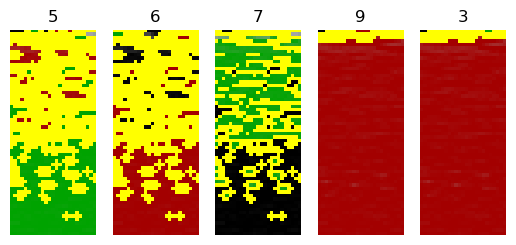

In [81]:
fig = plt.subplots(1, topclasses)
for i in range(0,topclasses):
    plt.subplot(1, topclasses, i+1)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plt.imshow(img_boundry2)
    plt.title(f'{classes[i]}')
    plt.axis('off')
plt.show()

The five plots shown are the five different classes with the highest probabilty from the model. In the above example we can see the areas that the model is using to predict a class. Evaluating these sections, we can begin to understand the parts of the image the model picks out to predict each class. Further examples of LIME for images can be found in this [notebook](https://github.com/marcotcr/lime/tree/master/doc/notebooks). This approach is similar to a saliency map which is a visualization technique to highlight the most important regions of an image. 

## Saliency Maps 
Saliency maps are a tool for deep learning models to visualize regions in an image that are captured inside a deep learning model. This can be done by finding an $L_2$-regularised image such that the score, $S_c(I)$, for a class, $c$, is maximized as:
$$
    \arg\max_I S_c(I) - \lambda||I||^2_2
$$
where $I$ is the image and $\lambda$ is the regularisation parameter. This is found by the back-propagation method (the same method used to optimise layer weights of a model). In this approach, the weight of the model are fixed and the optimization is performed with respect to the $I$. Pixels are ranked based on their influence to the class score $S_c(I)$ and the pixels that affect the class score the most are highlighted. Although we define this breifly here, further details of this approach can be found [here](https://arxiv.org/abs/1312.6034). Below we demonstrate this technique for a particular sample of our dataset.

In [82]:
# Define saliency map function 
## This code was taken from https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb 
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transform input image to torch.Tensor and normalize
    input = torch.from_numpy(img[None,None,:,:])

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = input[0]
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

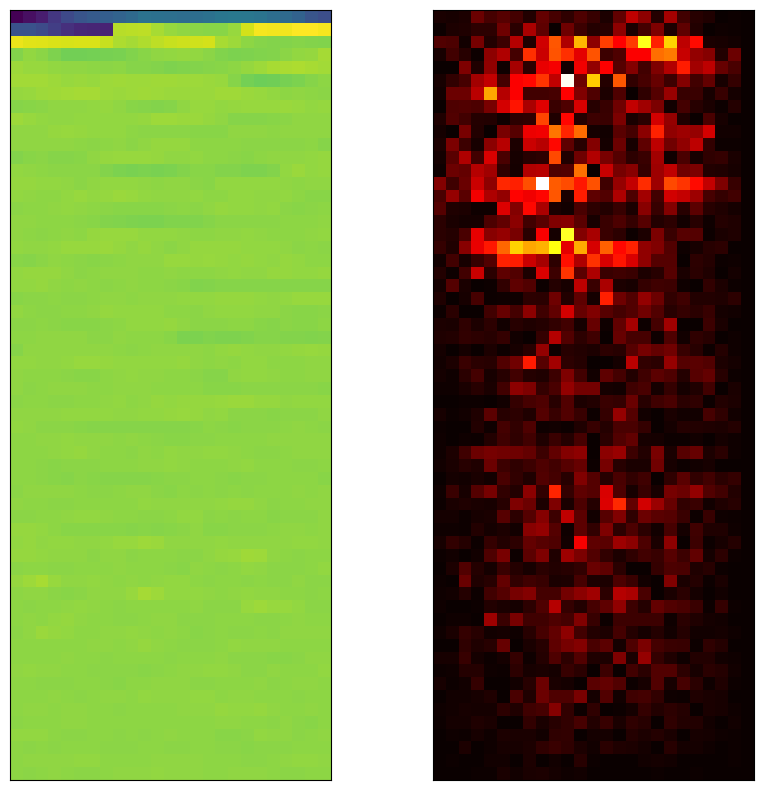

In [83]:
saliency(dataex, net)

The left plot shows the original MFCC image extracted from our example sound and the right shows the saliency map. We can see certain areas of the image light up which correspond to pixels of importance, the brighter the area, the higher the importance.

# Final Notes
We have demonstrated a number of different topics in this notebook from statistical evaluation of models to visualization of pixel activations for deep learning models. Although we have covered a large spread of different methods to evaluate and undrstand model predictions, we would like to point out that this is only an introduction to ML model evaluation and understanding. Further research is currently being done to dive deeper into machine learning models and understand how they make highly accurate predictions. There is a growing need to understand and improve on these models ultimately improving the speed of our research and how we conduct it. As researchers, students, and model developers we must continue to push toward interpretability and develop a higher understanding in ML.

# Citations
1) Scott M. Lundberg and Su-In Lee. 2017. A unified approach to interpreting model predictions. In Proceedings of the 31st International Conference on Neural Information Processing Systems (NIPS'17). Curran Associates Inc., Red Hook, NY, USA, 4768–4777.
2) Marco Tulio Ribeiro, Sameer Singh, and Carlos Guestrin. 2016. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). Association for Computing Machinery, New York, NY, USA, 1135–1144. https://doi.org/10.1145/2939672.2939778
3) Jolliffe, I. T. Principal Component Analysis. 2nd ed., Springer, 2002.
4) Tenenbaum, J.B.; De Silva, V.; & Langford, J.C., “A global geometric framework for nonlinear dimensionality reduction,” Science 290 (5500)
5) Borg, I.; Groenen P., “Modern Multidimensional Scaling - Theory and Applications,” Springer Series in Statistics (1997)
6) “Web Scale K-Means clustering” D. Sculley, Proceedings of the 19th international conference on World wide web (2010)
7) M. Belkin and P. Niyogi, "Laplacian Eigenmaps for Dimensionality Reduction and Data Representation," in Neural Computation, vol. 15, no. 6, pp. 1373-1396, 1 June 2003, doi: 10.1162/089976603321780317.
8) Davies, David L.; Bouldin, Donald W. (1979). “A Cluster Separation Measure”. IEEE Transactions on Pattern Analysis and Machine Intelligence. PAMI-1 (2): 224-227
9) L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.
10) van der Maaten, L., & Hinton, G. (2008). Visualizing Data using t-SNE. Journal of Machine Learning Research, 9(86), 2579–2605. Retrieved from http://jmlr.org/papers/v9/vandermaaten08a.html
11) Simonyan, K., Vedaldi, A., & Zisserman, A. (2014). Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps. arXiv [Cs.CV]. Retrieved from http://arxiv.org/abs/1312.6034